# Принятие решений в бизнесе. Приоритизация гипотез.

# Введение.

В данном проекте наша задача - приоритизировать гипотезы, запустить A/B-тест и верно интерпретировать его результаты.

Глобально порядок действий будет таков:

1. Приоритизировать гипотезы посредством применения фреймворков `ICE` (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») и `RICE` (R от англ. reach, «охват»).
2. Проанализировать результаты A/B-теста, опираясь на различные метрики.

## Обзор данных.

Посмотрим на данные. В отдельной ячейке импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

Выгрузим датасеты, присвоим их переменным и выведем на экран.

Датасет для первой части исследования.

In [2]:
hyp_data = pd.read_csv('/datasets/hypothesis.csv')
pd.options.display.max_colwidth = 110
hyp_data.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Приведем названия колонок датасета к нижнему регистру.

In [3]:
hyp_data.columns = map(str.lower, hyp_data.columns)

Датасеты для второй части исследования.

In [4]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')
display(orders.head())
visitors.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Проверим датасеты на наличие пропусков и дубликатов.

In [5]:
hyp_data.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

In [6]:
hyp_data.duplicated().sum()

0

In [7]:
display(orders.isna().sum())
visitors.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

In [8]:
display(orders.duplicated().sum())
visitors.duplicated().sum()

0

0

Описание данных.

In [9]:
hyp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

За исклбчением приведения названий колонок датасета `hyp_data` к нижнему регистру, проблем в данных не обнаружено. Можно переходить к первому шагу исследования.

## Часть 1. Приоритизация гипотез.

Для приоритизации гипотез будем применять фреймворки `ICE` и `RICE`.

### Фреймворк `ICE`.

In [12]:
hyp_data['ICE'] = (hyp_data['impact'] * hyp_data['confidence']) / hyp_data['efforts']

hyp_data[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Судя по полученным результатам работы фреймворка `ICE` наиболее перспективными гипотезами являются гипотезы под номерами **8**, **0** и **7**. Проверим, что изменится, если вместо фреймворка `ICE` применить фреймворк `RICE`.

### Фреймворк `RICE`.

In [13]:
hyp_data['RICE'] = (hyp_data['reach'] * hyp_data['impact'] * hyp_data['confidence']) / hyp_data['efforts']

print(hyp_data[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                                                                                     hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

Судя по результатам работы `RICE` наиболее преспективной гипотезой является гипотеза под номером **7**. В прошлых результатх она тоже присутствовала, но была на "третьем месте". А сейчас она лидирует.
Это произошло потому, что ее параметр `reach` (от англ. "охват") **больше**, чем у остальных гипотез. Можно сделать вывод, что **седьмая** гипотеза наиболее перспективная. 

Анализ работы фреймворков `ICE` и `RICE` завершен, можно переходить к анализам A/B-теста.

## Часть 2. Анализ результатов A/B-тестирования.

### График кумулятивной выручки по группам.

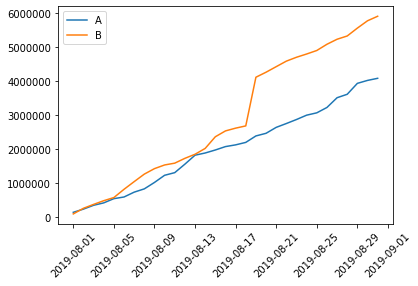

In [14]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d') # переводим даты в правильный формат
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

datesGroups = orders[['date', 'group']].drop_duplicates() # создаем массив уникальных пар значений дат и групп теста

# получаем агрегированные кумулятивные по дням данные о заказах 

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе В

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation = 45)

plt.legend()

Чуть позже середины теста сегмент В занчительно вырывается вперед и остается лидировать до конца теста. Возможно, что в данных есть выбросы (аномально большие заказаы).

### График кумулятивного среднего чека по группам.

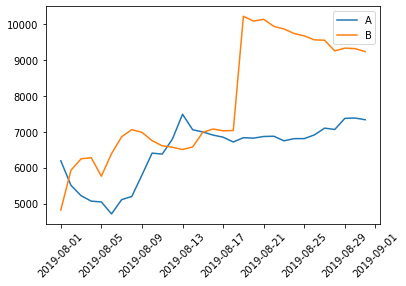

In [15]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation = 45)
plt.legend()

Судя по графику, делать какие-либо выводы пока рано, графики слишком сильно колеблются. Возможно эти колебания также происходят из-за выбросов.

### График относительного изменения кумулятивного среднего чека группы B к группе A.

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

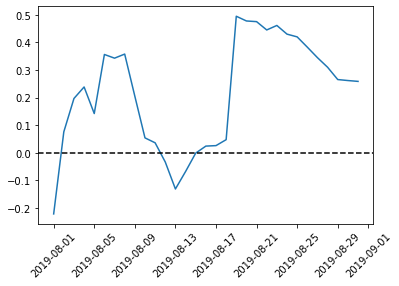

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation = 45)

Судя по графику, "аномальные" заказы были совершены именно в те даты, в момент которых на графике наиболее сильные колебания.

### График кумулятивной конверсии по группам. 

[datetime.datetime(2019, 8, 1, 0, 0),
 datetime.datetime(2019, 9, 1, 0, 0),
 0,
 0.05]

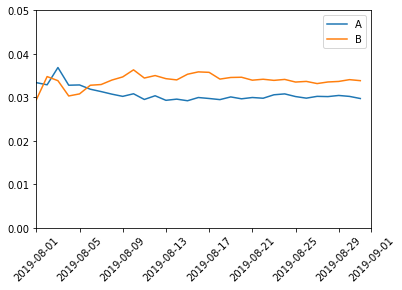

In [17]:
# добавим в датафрейм столбец conversion с отношением числа заказов к количеству пользователей
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation = 45)
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])

Если бы мы не задали масштаб графиков, было видно, что колебания продолжаются. С установленным масштабом видно, что величина колебаний не превышает 1%. Что же относительно самого графика, то на нем видно, что группа А в начале лидировала, затем конверсия группы В превысила конверсию группы А и была стаибильна на протяжении всего теста. 

### График относительного изменения кумулятивной конверсии группы B к группе A.

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

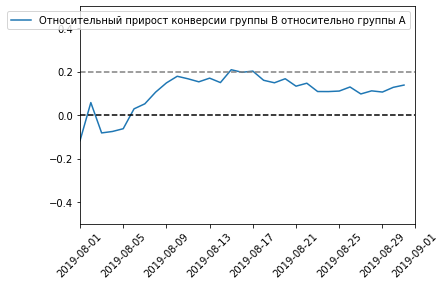

In [18]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5]) 
plt.xticks(rotation = 45)

Практически сразу же после начала теста группа В вырывается вперед и лидирует до самого конца теста. 

### Точечный график количества заказов по пользователям.

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


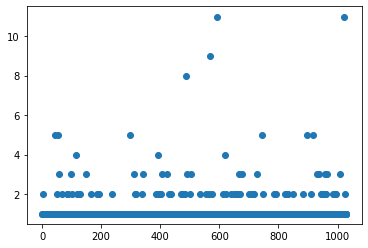

In [19]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 

На графике выидно, что пользователей, сделавших более двух заказщов совсем мало. Это вполне может быть аномальным значением.

### 95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей.

In [20]:
display(ordersByUsers.sort_values(by='orders', ascending=False).head(10))
np.percentile(ordersByUsers['orders'], [95, 99]) 
 # Метод np.percentile('column', [percentile1, percentile2, percentile3]) находит перцентили.

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


array([2., 4.])

Не более 1% пользователей совершили более четырех заказов и не более 5% пользователй соврешили более 2 заказов.

### Точечный график стоимостей заказов.

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


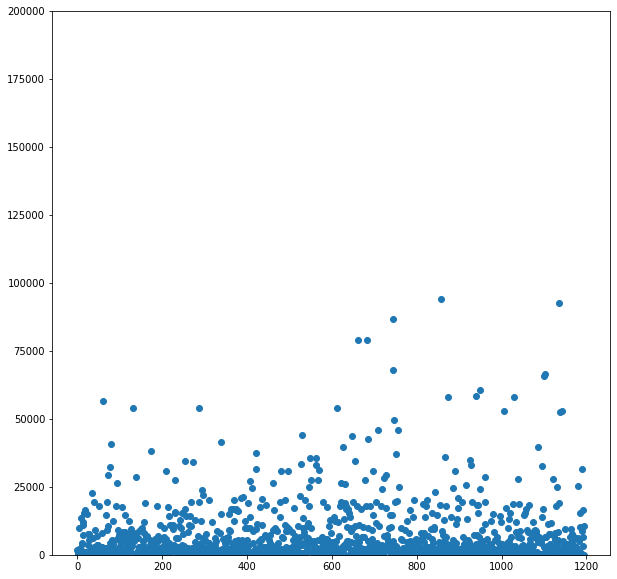

In [21]:
display(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(10, 10))
plt.ylim([0, 200000])
plt.scatter(x_values, orders['revenue']) 

Есть аномальный заказ на сумму около полутора миллионов. В целом суммы не превышают 100 000.

### 95-й и 99-й перцентили стоимости заказов. Граница для определения аномальных заказов.

In [22]:
display(orders.head(10))

np.percentile(orders['revenue'], [95, 99]) 

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


array([28000. , 58233.2])

Не более чем у 5% заказов чек больше 28000. У 1% заказов чек больше 58233.

### Статистическая значимость различий в конверсии между группами по «сырым» данным.

Сформулируем нулевую и альтернативную гипотезы.

**Нулевая гипотеза** - статистически значимых различий между группами нет.
**Альтернативная** - статистически значимые различия между группами есть.

In [23]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

display("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
 
"{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


'0.00840'

'0.138'

Значение p-value намного  меньше 5%. Нулевую гипотезу можно отвергнуть в том смысле, что анализ "сырых данных" показывает, что в конверсии между группами есть значимые раздичия. Относительный прирост конверсии сегмента В по отношению к конверсии сегмента А составляет 13.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

На данном шаге также объявим гипотезы:

**Нулевая** - статистически значимых различий в плане среднего чека заказов между группами нет.
**Альтернативная** - статистически значимые различия в плане среднего чека между группами есть.

In [24]:
display('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'0.365'

'0.259'

P-value намного больше 5%, значит значимых различий в среднем чеке между группами нет. Однако прирост среднего чека группы В составляет 25%.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным.

In [25]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 20000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

display('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
'{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)

'0.01147'

'0.149'

Проверка коэффициентов по "очищенным" практически не отличается от проверки по "сырым". Сегмент В показывает себя лучше сегмента А.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [26]:
display(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

display(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

'0.433'

'-0.002'

P-value увеличился а статистическое различие между группами снизилось.

<div class="alert alert-success">

<b>✔️ Комментарий ревьюера:</b> По "сырым" данным сегмент B вел по среднему чеку на 26%, а теперь он проигрывает на 2%. Но при этом в обоих случаях эта разница статистически незначима

</div>

## Вывод.

Судя по "чистым" результатам теста можно сказать что статистически значимого различия между группами нет. Следовательно, можно сделать вывод, что **A/B-тест можно заврешить, так как по чистым данным различий между группами нет**.